## Import Package and Data

In [99]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from jcopml.time_series.decomposition import additive_decomposition, multiplicative_decomposition

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from calendar import day_name
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore") 

In [100]:
df = pd.read_csv("data.csv")
df['date'] = pd.to_datetime(df['date'])
df.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


## Data Cleaning

In [101]:
print("Data memiliki", df.shape[0], "baris dan", df.shape[1], "kolom")

Data memiliki 142524 baris dan 14 kolom


In [102]:
missing_value = df[df.columns[(df.isna().sum() > 0)]]
duplicate_data = df.duplicated().sum()
print("Missing Value")
print(missing_value.isnull().sum())
print("\nDuplicate Data", duplicate_data, "Row")

Missing Value
occu_perc    125
capacity     125
dtype: int64

Duplicate Data 106 Row


In [103]:
pd.DataFrame(data = [df.isna().sum()/df.shape[0]*100],
             index=["Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Null (%)
film_code,0.000000
cinema_code,0.000000
total_sales,0.000000
tickets_sold,0.000000
tickets_out,0.000000
show_time,0.000000
occu_perc,0.087705
ticket_price,0.000000
ticket_use,0.000000
capacity,0.087705


### Membuat Data yang duplikat dan missing value

In [104]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True, keep='first')

In [105]:
missing_value = df[df.columns[(df.isna().sum() > 0)]]
duplicate_data = df.duplicated().sum()
print("Missing Value")
print(missing_value.isnull().sum())
print("\nDuplicate Data", duplicate_data, "Row")

Missing Value
Series([], dtype: float64)

Duplicate Data 0 Row


# Exploratory Data Analysis

### Melihat Kolom Film Code

In [106]:
print(len(df['film_code'].value_counts()), "Jenis Film\n")
print(df['film_code'].value_counts())

48 Jenis Film

1554    11613
1493    10490
1481     9525
1484     8519
1482     7394
1556     6979
1483     6970
1485     6073
1494     6022
1498     5544
1499     5187
1576     4431
1497     3911
1559     3649
1572     3581
1558     3548
1511     3250
1495     2958
1553     2850
1573     2444
1552     2444
1486     2294
1551     2268
1562     2144
1578     1847
1575     1589
1496     1443
1480     1386
1563     1301
1492     1086
1564     1044
1569      987
1560      931
1550      678
1568      663
1500      633
1502      601
1512      565
1566      558
1571      552
1471      466
1557      418
1587      414
1570      341
1565      313
1567      285
1589       67
1584       39
Name: film_code, dtype: int64


### Melihat Kolom Cinema Code

In [107]:
print(len(df['cinema_code'].value_counts()), "Jenis Cinema\n")
print(df['cinema_code'].value_counts())

244 Jenis Cinema

524    2473
489    2406
448    2344
163    2240
518    2192
       ... 
376      22
520      12
565      10
566       2
424       1
Name: cinema_code, Length: 244, dtype: int64


### Membuat Kolom Film ID

In [108]:
df['film_id'] = df[['film_code','cinema_code','date']].apply(lambda row:'_'.join(row.values.astype(str)), axis=1)
df = df[['film_id'] + [a for a in df.columns if a != 'film_id']]

df.head()

,film_id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492_304_2018-05-05 00:00:00,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492_352_2018-05-05 00:00:00,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492_489_2018-05-05 00:00:00,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492_429_2018-05-05 00:00:00,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492_524_2018-05-05 00:00:00,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


Kolom Film ID merupakan gabungan dari Kolom Film Code, Cinema Code, dan Date untuk melihat apakah terdapat data yang duplikat

### Melihat Duplicate Data

In [109]:
print("Duplicate Data Film ID\t", df['film_id'].duplicated().sum())

Duplicate Data Film ID	 0


Pada Kolom Film ID, tidak terdapat duplicate data

## Visualisasi

In [110]:
#sns.pairplot(df, hue='film_code', corner=True)

<AxesSubplot:xlabel='total_sales', ylabel='tickets_sold'>

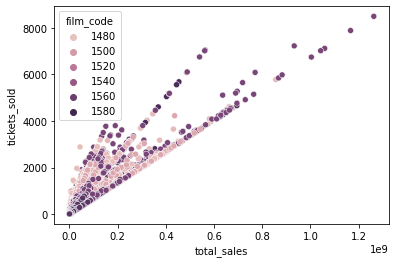

In [111]:
sns.scatterplot(x='total_sales', y='tickets_sold', data=df, hue='film_code')

<AxesSubplot:xlabel='month'>

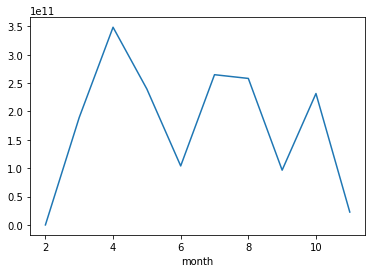

In [112]:
line = df.groupby('month').sum()
line['total_sales'].plot()

<AxesSubplot:xlabel='date'>

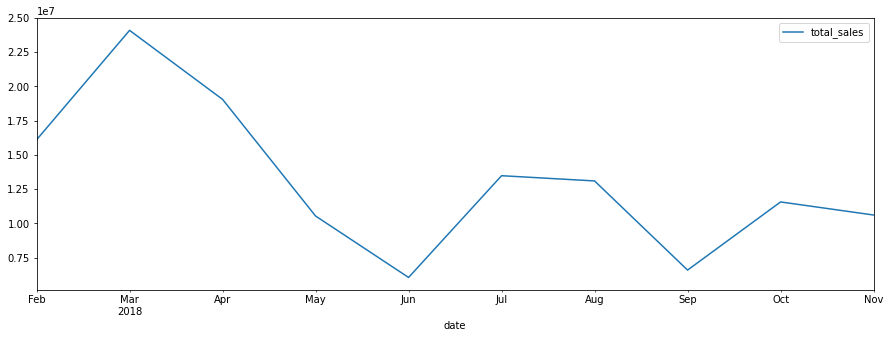

In [113]:
series = df[['total_sales', 'date']]
series = series.set_index('date')
series = series.resample('M').mean()
series.plot(figsize=(15,5))

## Statistic

In [114]:
df.head()

,film_id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492_304_2018-05-05 00:00:00,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492_352_2018-05-05 00:00:00,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492_489_2018-05-05 00:00:00,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492_429_2018-05-05 00:00:00,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492_524_2018-05-05 00:00:00,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


In [115]:
numeric = ['total_sales', 'tickets_sold', 'ticket_price', 'ticket_use', 'capacity', 'show_time', 'occu_perc', 'tickets_out']
df[numeric].describe()

,total_sales,tickets_sold,ticket_price,ticket_use,capacity,show_time,occu_perc,tickets_out
count,1.422950e+05,142295.000000,142295.000000,142295.000000,142295.000000,142295.000000,142295.000000,142295.000000
mean,1.233833e+07,140.097944,81239.000455,139.860452,854.570014,3.933357,19.955645,0.237493
std,3.062706e+07,279.704392,33239.397517,279.510181,952.940018,3.056759,22.648393,2.925276
min,2.000000e+04,1.000000,483.870968,-219.000000,-2.000000,1.000000,0.000000,0.000000
25%,1.270000e+06,18.000000,60000.000000,18.000000,276.497696,2.000000,3.750000,0.000000
50%,3.720000e+06,50.000000,79448.266667,50.000000,525.131283,3.000000,10.340000,0.000000
75%,1.110000e+07,143.000000,100000.000000,143.000000,1038.961039,5.000000,28.210000,0.000000
max,1.262820e+09,8499.000000,700000.000000,8499.000000,9692.097160,60.000000,147.500000,311.000000


In [116]:
df_categoric = df.copy()
categoric = ['film_code', 'cinema_code']
df_categoric['film_code'] = df['film_code'].astype('category')
df_categoric['cinema_code'] = df['cinema_code'].astype('category')
df_categoric[categoric].describe()

,film_code,cinema_code
count,142295,142295
unique,48,244
top,1554,524
freq,11613,2473


In [117]:
tiket = df.groupby('film_code').sum()
tiket[['tickets_sold', 'total_sales']].sort_values(ascending=False, by='tickets_sold')

,tickets_sold,total_sales
film_code,,
1554,4129443,372730716637
1484,1753967,147010737334
1493,1719861,144169141258
1482,1628733,130522874406
1483,1623481,156909698770
1481,1160874,79048046436
1576,968860,95054918934
1485,959784,90773918382
1556,635615,55469649968


In [118]:
print("Film Code Unique Data\t", df['film_code'].nunique())
print("Cinema Code Unique Data\t", df['cinema_code'].nunique())
print("Month Unique Data\t", df['month'].nunique())
print("Quarter Unique Data\t", df['quarter'].nunique())
print("Day Unique Data\t\t", df['day'].nunique())

Film Code Unique Data	 48
Cinema Code Unique Data	 244
Month Unique Data	 10
Quarter Unique Data	 4
Day Unique Data		 31


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142295 entries, 0 to 142523
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   film_id       142295 non-null  object        
 1   film_code     142295 non-null  int64         
 2   cinema_code   142295 non-null  int64         
 3   total_sales   142295 non-null  int64         
 4   tickets_sold  142295 non-null  int64         
 5   tickets_out   142295 non-null  int64         
 6   show_time     142295 non-null  int64         
 7   occu_perc     142295 non-null  float64       
 8   ticket_price  142295 non-null  float64       
 9   ticket_use    142295 non-null  int64         
 10  capacity      142295 non-null  float64       
 11  date          142295 non-null  datetime64[ns]
 12  month         142295 non-null  int64         
 13  quarter       142295 non-null  int64         
 14  day           142295 non-null  int64         
dtypes: datetime64[ns]

# Korelasi

In [120]:
korelasi = df.copy()
korelasi.drop(columns=['film_id', 'month', 'day', 'quarter'], inplace=True)
korelasi.corr()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity
film_code,1.000000,0.028854,0.010380,-0.005139,-0.000929,0.076987,-0.103775,0.105387,-0.005133,0.061434
cinema_code,0.028854,1.000000,-0.013376,-0.054077,0.019478,-0.187179,0.125683,0.005649,-0.054318,-0.353412
total_sales,0.010380,-0.013376,1.000000,0.915126,0.066949,0.510570,0.414309,0.271907,0.915062,0.376257
tickets_sold,-0.005139,-0.054077,0.915126,1.000000,0.071597,0.522458,0.493702,0.102925,0.999946,0.425518
tickets_out,-0.000929,0.019478,0.066949,0.071597,1.000000,0.078917,0.044441,0.011996,0.061181,0.037631
show_time,0.076987,-0.187179,0.510570,0.522458,0.078917,1.000000,0.055602,0.176133,0.521995,0.681653
occu_perc,-0.103775,0.125683,0.414309,0.493702,0.044441,0.055602,1.000000,0.084356,0.493580,-0.141135
ticket_price,0.105387,0.005649,0.271907,0.102925,0.011996,0.176133,0.084356,1.000000,0.102871,0.004297
ticket_use,-0.005133,-0.054318,0.915062,0.999946,0.061181,0.521995,0.493580,0.102871,1.000000,0.425420
capacity,0.061434,-0.353412,0.376257,0.425518,0.037631,0.681653,-0.141135,0.004297,0.425420,1.000000


In [121]:
korelasi.corr()['total_sales'].sort_values(ascending=False)

total_sales     1.000000
tickets_sold    0.915126
ticket_use      0.915062
show_time       0.510570
occu_perc       0.414309
capacity        0.376257
ticket_price    0.271907
tickets_out     0.066949
film_code       0.010380
cinema_code    -0.013376
Name: total_sales, dtype: float64

In [122]:
df.head()

,film_id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492_304_2018-05-05 00:00:00,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492_352_2018-05-05 00:00:00,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492_489_2018-05-05 00:00:00,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492_429_2018-05-05 00:00:00,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492_524_2018-05-05 00:00:00,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


# Mengatasi Outliers

In [123]:
df.head()

,film_id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492_304_2018-05-05 00:00:00,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492_352_2018-05-05 00:00:00,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492_489_2018-05-05 00:00:00,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492_429_2018-05-05 00:00:00,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492_524_2018-05-05 00:00:00,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


In [124]:
# fig, axes = plt.subplots(4,2, figsize=(20,20))
# sns.boxplot(x="total_sales", data=df, ax=axes[0, 0])
# sns.boxplot(x="tickets_sold", data=df, ax=axes[0, 1])
# sns.boxplot(x="ticket_price", data=df, ax=axes[1, 0])
# sns.boxplot(x="ticket_use", data=df, ax=axes[1, 1])

# sns.boxplot(x="capacity", data=df, ax=axes[2, 0])
# sns.boxplot(x="show_time", data=df, ax=axes[2, 1])
# sns.boxplot(x="occu_perc", data=df, ax=axes[3, 0])
# sns.boxplot(x="tickets_out", data=df, ax=axes[3, 1])

In [125]:
# numeric = ['total_sales', 'tickets_sold', 'ticket_price', 'ticket_use', 'capacity', 'show_time', 'occu_perc', 'tickets_out']

# old = df.shape
# df_forecast = df.copy()

# z = np.abs(stats.zscore(df[numeric]))
# df = (df[(z<3).all(axis=1)])

# new = df.shape
# print("Jumlah data sebelum ZScore : ", old)
# print("Jumlah data sesudah ZScore : ", new)

In [126]:
# fig, axes = plt.subplots(4,2, figsize=(20,20))
# sns.boxplot(x="total_sales", data=df, ax=axes[0, 0])
# sns.boxplot(x="tickets_sold", data=df, ax=axes[0, 1])
# sns.boxplot(x="ticket_price", data=df, ax=axes[1, 0])
# sns.boxplot(x="ticket_use", data=df, ax=axes[1, 1])

# sns.boxplot(x="capacity", data=df, ax=axes[2, 0])
# sns.boxplot(x="show_time", data=df, ax=axes[2, 1])
# sns.boxplot(x="occu_perc", data=df, ax=axes[3, 0])
# sns.boxplot(x="tickets_out", data=df, ax=axes[3, 1])

# Columns Transformer

In [127]:
df.head()

,film_id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492_304_2018-05-05 00:00:00,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492_352_2018-05-05 00:00:00,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492_489_2018-05-05 00:00:00,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492_429_2018-05-05 00:00:00,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492_524_2018-05-05 00:00:00,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


### Membuat Kolom Year

In [128]:
parse_date = df['date'].dt

df['year'] = parse_date.year
df['year'].value_counts()

2018    142295
Name: year, dtype: int64

### Mengatasi Kolom Capacity 

In [129]:
df['capacity'] = df['capacity'].round()
df['capacity'].describe()

count    142295.000000
mean        854.569865
std         952.937922
min          -2.000000
25%         276.000000
50%         525.000000
75%        1039.000000
max        9692.000000
Name: capacity, dtype: float64

In [130]:
df = df[(df['capacity'] >= 0)]
df['capacity'].describe()

count    142241.000000
mean        854.895051
std         952.972601
min          10.000000
25%         278.000000
50%         526.000000
75%        1039.000000
max        9692.000000
Name: capacity, dtype: float64

### Mengatasi Kolom ticket_use

In [131]:
df = df[(df['ticket_use'] >= 0)]
df['ticket_use'].describe()

count    142180.000000
mean        139.966775
std         279.588504
min           0.000000
25%          18.000000
50%          50.000000
75%         143.000000
max        8499.000000
Name: ticket_use, dtype: float64

# Evaluasi Model Function

In [132]:
method_list=[] #going to hold the method
algorithm_list = [] #specific algorithm
rmse_list =[] # root mean squared error
mse_list = [] #mean squared error
mae_list = [] #mean absolute error
r2_list = [] #correlation square -tells us how good does the data fit the line
d = {
    'Method': method_list,
    'Algorithm':algorithm_list,
    'MSE': mse_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'R2': r2_list
}

def get_metric(actual,predicted,method,algorithm):
    #compute metrics
    mse = mean_squared_error(actual,predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual,predicted)
    r2 = r2_score(actual,predicted)
    
    # append list
    method_list.append(method)
    algorithm_list.append(algorithm)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    result = pd.DataFrame(d)
    return result

# Forecasting Check

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142180 entries, 0 to 142523
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   film_id       142180 non-null  object        
 1   film_code     142180 non-null  int64         
 2   cinema_code   142180 non-null  int64         
 3   total_sales   142180 non-null  int64         
 4   tickets_sold  142180 non-null  int64         
 5   tickets_out   142180 non-null  int64         
 6   show_time     142180 non-null  int64         
 7   occu_perc     142180 non-null  float64       
 8   ticket_price  142180 non-null  float64       
 9   ticket_use    142180 non-null  int64         
 10  capacity      142180 non-null  float64       
 11  date          142180 non-null  datetime64[ns]
 12  month         142180 non-null  int64         
 13  quarter       142180 non-null  int64         
 14  day           142180 non-null  int64         
 15  year          142

<AxesSubplot:xlabel='date'>

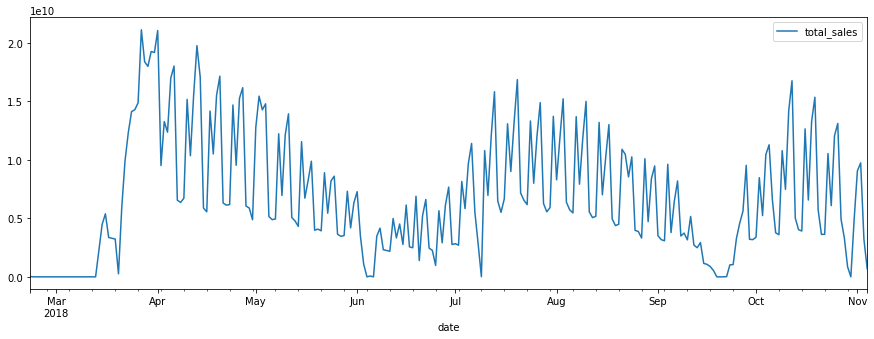

In [134]:
series = df.copy()
series.set_index('date', inplace=True)
data = series[['total_sales']]
data = data.resample('D').sum()
data.plot(figsize=(15,5))

In [135]:
data.head()

,total_sales
date,
2018-02-21,32030000
2018-02-22,0
2018-02-23,180000
2018-02-24,0
2018-02-25,0


In [136]:
from jcopml.time_series import stationarity_tester

In [137]:
stationarity_tester(data)

ADF:        Series is stationary
KPSS:       Series is trend stationary
Conclusion: Series is stationary


,Test Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),reject_null
ADF,-3.138979,0.0238,-3.457664,-2.873559,-2.573175,True
KPSS,0.131238,0.1000,0.739000,0.463000,0.347000,False


Modeling with difference periods = 1

### Forecasting with SARIMAX

In [138]:
from pmdarima import auto_arima

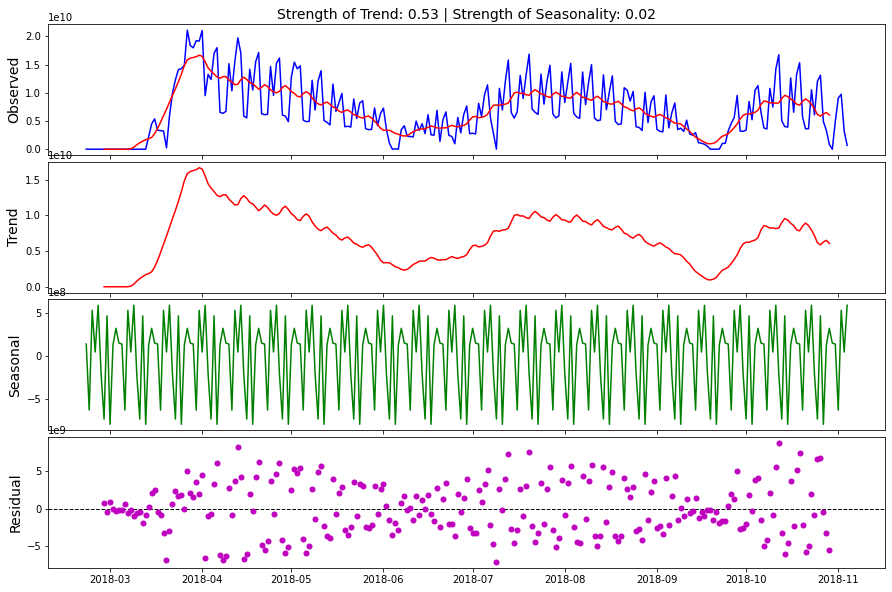

In [139]:
components = additive_decomposition(data, plot=True, period=12)

In [140]:
X_train, X_test = data[:-25], data[-25:]

arima = auto_arima(X_train, seasonal=True, m=12, information_criterion='aicc', trace=True, suppress_warnings=True, random_state=42)

Performing stepwise search to minimize aicc
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AICC=inf, Time=1.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AICC=11040.169, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AICC=10895.807, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AICC=10950.876, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AICC=11270.236, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AICC=10893.741, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AICC=10895.793, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AICC=10897.861, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AICC=10889.781, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AICC=10890.609, Time=0.52 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AICC=10890.536, Time=0.22 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AICC=10892.638, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AICC=10888.384, Time=0.08 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AICC=10890.317, Time=0.40 

In [141]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  232
Model:             SARIMAX(5, 0, 2)x(0, 0, [1], 12)   Log Likelihood               -5402.410
Date:                              Fri, 30 Dec 2022   AIC                          10824.820
Time:                                      18:54:20   BIC                          10859.287
Sample:                                  02-21-2018   HQIC                         10838.720
                                       - 10-10-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.11e+09   2.19e-12   5.08e+20      0.000    1.11e+09    1.11e+09
ar.L1         -0.7443      0.107     -6.983      0.000      -0.953      -0.535
ar.L2          0.3677      0.123      2.986      0.003       0.126       0.609
ar.L3          0.5423      0.106      5.105      0.000       0.334       0.751
ar.L4          0.2300      0.135      1.698      0.090      -0.036       0.496
ar.L5          0.3857      0.096      4.037      0.000       0.198       0.573
ma.L1          1.5623      0.091     17.212      0.000       1.384       1.740
ma.L2          0.7626      0.083      9.193      0.000       0.600       0.925
ma.S.L12      -0.3132      0.112     -2.795      0.005      -0.533      -0.094
sigma2      1.254e+19   4.14e-21   3.03e+39      0.000    1.25e+19    1.25e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                12.00
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+55. Standard errors may be unstable.
"""

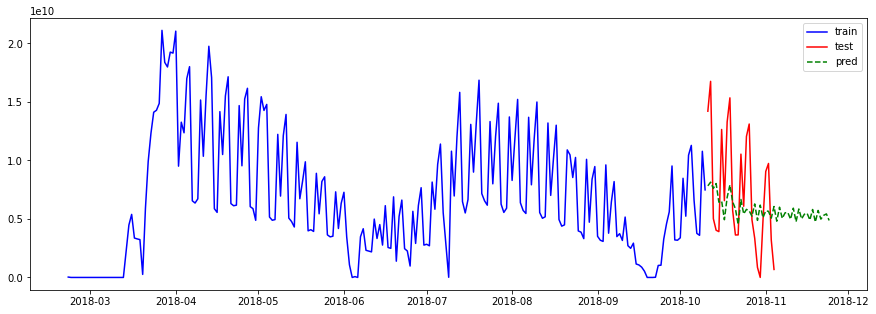

In [142]:
n_forecast = len(X_test) + 20
pred = arima.predict(n_forecast)

plt.figure(figsize=(15,5))
plt.plot(X_train, "b-", label="train")
plt.plot(X_test, "r-", label="test")
plt.plot(pred, "g--", label="pred")
plt.legend()

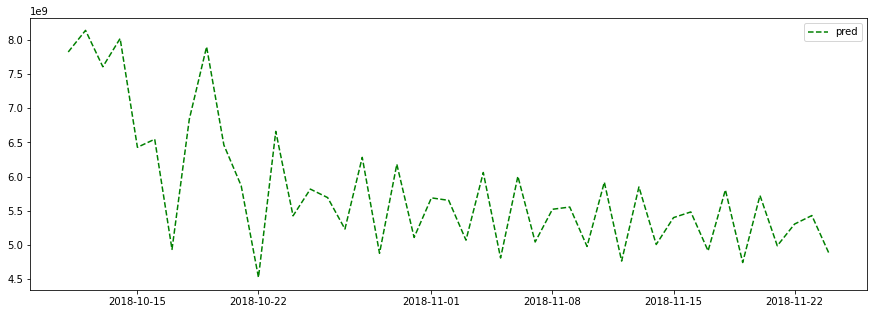

In [143]:
plt.figure(figsize=(15,5))
plt.plot(pred, "g--", label="pred")
plt.legend()

In [144]:
pred = arima.predict(25)[:25]
actual = df['total_sales'][:25]

mse_sarimax = mean_squared_error(actual, pred)
rmse_sarimax = np.sqrt(mse_sarimax)
mae_sarimax = mean_absolute_error(actual,pred)
r2_sarimax = r2_score(actual,pred)

print("MSE\t: ", mse_sarimax)
print("RMSE\t: ", rmse_sarimax)
print("MAE\t: ", mae_sarimax)
print("R2\t: ", r2_sarimax)

MSE	:  3.938823934949966e+19
RMSE	:  6276005046.96257
MAE	:  6189970075.517405
R2	:  -2247800.746198961


In [145]:
get_metric(actual, pred, "Time Series", "SARIMAX")

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,3.938824e+19,6.276005e+09,6.189970e+09,-2.247801e+06


# Forecasting with ARIMA

In [146]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

<AxesSubplot:xlabel='date'>

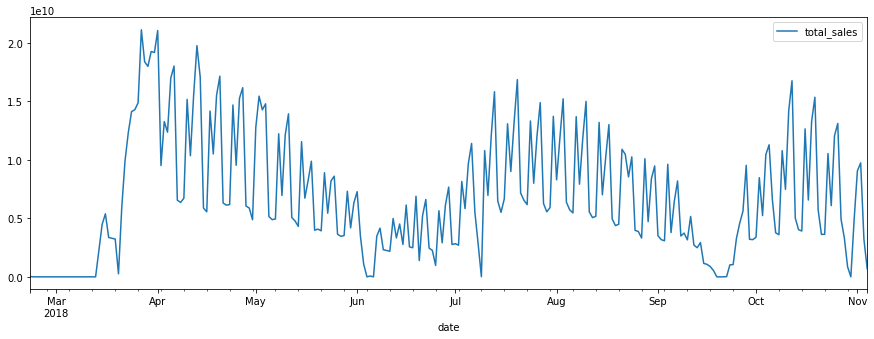

In [147]:
series = df.copy()
series.set_index('date', inplace=True)
data = series[['total_sales']]
data = data.resample('D').sum()
data.plot(figsize=(15,5))

In [148]:
X_train, X_test = data[:-25], data[-25:]

arima = auto_arima(X_train, seasonal=True, m=12, information_criterion='aicc', trace=True, suppress_warnings=True, random_state=42)

Performing stepwise search to minimize aicc
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AICC=inf, Time=1.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AICC=11040.169, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AICC=10895.807, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AICC=10950.876, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AICC=11270.236, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AICC=10893.741, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AICC=10895.793, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AICC=10897.861, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AICC=10889.781, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AICC=10890.609, Time=0.46 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AICC=10890.536, Time=0.19 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AICC=10892.638, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AICC=10888.384, Time=0.07 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AICC=10890.317, Time=0.33 

In [149]:
model = ARIMA(X_train, order=(5,0,2))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            total_sales   No. Observations:                  232
Model:                 ARIMA(5, 0, 2)   Log Likelihood               -5406.757
Date:                Fri, 30 Dec 2022   AIC                          10831.513
Time:                        18:55:02   BIC                          10862.534
Sample:                    02-21-2018   HQIC                         10844.023
                         - 10-10-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.777e+09   5.19e-12   1.31e+21      0.000    6.78e+09    6.78e+09
ar.L1         -0.8620      0.098     -8.836      0.000      -1.053      -0.671
ar.L2          0.2074      0.114      1.824      0.0

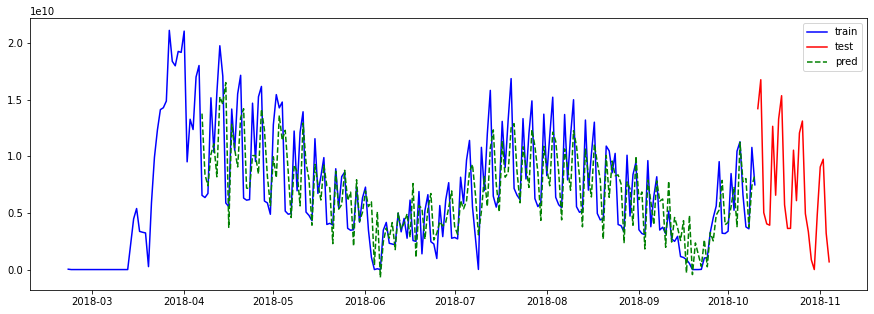

In [150]:
n_forecast = len(X_test) + 20
pred = results.predict(n_forecast)

plt.figure(figsize=(15,5))
plt.plot(X_train, "b-", label="train")
plt.plot(X_test, "r-", label="test")
plt.plot(pred, "g--", label="pred")
plt.legend()

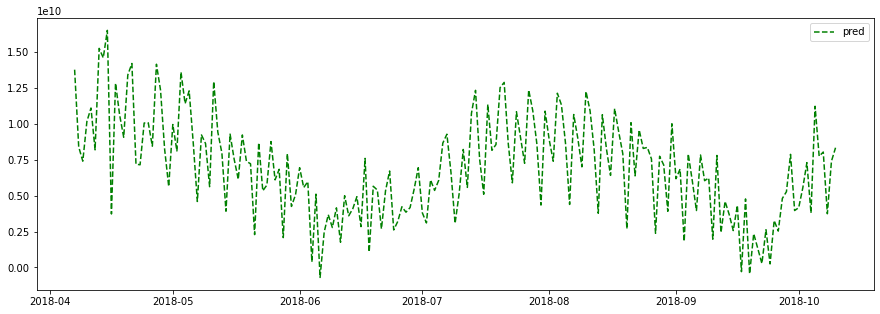

In [151]:
plt.figure(figsize=(15,5))
plt.plot(pred, "g--", label="pred")
plt.legend()

In [152]:
pred = results.predict(25)[:25]
actual = df['total_sales'][:25]

mse_arima = mean_squared_error(actual, pred)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(actual,pred)
r2_arima = r2_score(actual,pred)

print("MSE\t: ", mse_arima)
print("RMSE\t: ", rmse_arima)
print("MAE\t: ", mae_arima)
print("R2\t: ", r2_arima)

MSE	:  1.4693251537976866e+20
RMSE	:  12121572314.669771
MAE	:  11148252517.83284
R2	:  -8385120.297589685


In [153]:
get_metric(actual, pred, "Time Series", "ARIMA")

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,3.938824e+19,6.276005e+09,6.189970e+09,-2.247801e+06
1,Time Series,ARIMA,1.469325e+20,1.212157e+10,1.114825e+10,-8.385120e+06


# Forecast with Model Machine Learning

Shifting the data with 7 periods

In [154]:
data = df.copy()
data.set_index('date', inplace=True)
df_model = data[['total_sales']]
df_model = df_model.resample('D').sum()

df_model['lag_1'] =  df_model['total_sales'].shift(periods=1)
df_model['lag_2'] =  df_model['total_sales'].shift(periods=2)
df_model['lag_3'] =  df_model['total_sales'].shift(periods=3)
df_model['lag_4'] =  df_model['total_sales'].shift(periods=4)
df_model['lag_5'] =  df_model['total_sales'].shift(periods=5)
df_model['lag_6'] =  df_model['total_sales'].shift(periods=6)
df_model['lag_7'] =  df_model['total_sales'].shift(periods=7)
df_model.fillna(0, inplace=True)
df_model.head(7)


,total_sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2018-02-21,32030000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-02-22,0,32030000.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-02-23,180000,0.0,32030000.0,0.0,0.0,0.0,0.0,0.0
2018-02-24,0,180000.0,0.0,32030000.0,0.0,0.0,0.0,0.0
2018-02-25,0,0.0,180000.0,0.0,32030000.0,0.0,0.0,0.0
2018-02-26,0,0.0,0.0,180000.0,0.0,32030000.0,0.0,0.0
2018-02-27,0,0.0,0.0,0.0,180000.0,0.0,32030000.0,0.0


### Splitting Data

In [155]:
def train_test_split(data, days):
    X_train = data.iloc[:-days , 1:]  # removing last 30 days and total_sales col
    y_train = data.iloc[:-days , :1] # removing last 30 days and only taking total_Sales col
    X_test = data.iloc[-days: , 1:]  # considering last 30 days without total sales
    y_test = data.iloc[-days: , :1]  # total sales of last 30 days
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(df_model, 30)

### Random Forest

In [156]:
from sklearn.ensemble import RandomForestRegressor

model_RF = RandomForestRegressor(n_jobs=-1, random_state=42)
model_RF.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [157]:
print('Training\t:', model_RF.score(X_train, y_train))
print('Testing\t\t:', model_RF.score(X_test, y_test))

Training	: 0.9578089712496521
Testing		: 0.6332954651404283


##### Hasil Training Random Forest

In [158]:
y_train_pred = model_RF.predict(X_train)

mse_RF = mean_squared_error(y_train,y_train_pred)
rmse_RF = np.sqrt(mse_RF)
mae_RF = mean_absolute_error(y_train,y_train_pred)
r2_RF = r2_score(y_train,y_train_pred)

print("MSE\t: ", mse_RF)
print("RMSE\t: ", rmse_RF)
print("MAE\t: ", mae_RF)
print("R2\t: ", r2_RF)

MSE	:  1.1451272553088384e+18
RMSE	:  1070106188.8003631
MAE	:  731042261.2913399
R2	:  0.9578089712496521


#### Hasil Testing Random Forest 

In [159]:
y_test_pred = model_RF.predict(X_test)

mse_RF = mean_squared_error(y_test,y_test_pred)
rmse_RF = np.sqrt(mse_RF)
mae_RF = mean_absolute_error(y_test,y_test_pred)
r2_RF = r2_score(y_test,y_test_pred)

print("MSE\t: ", mse_RF)
print("RMSE\t: ", rmse_RF)
print("MAE\t: ", mae_RF)
print("R2\t: ", r2_RF)

MSE	:  7.597239276338391e+18
RMSE	:  2756308995.0762763
MAE	:  1954331992.758334
R2	:  0.6332954651404283


#### Hasil

In [160]:
get_metric(y_test, y_test_pred, "Time Series", "Random Forest")

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,3.938824e+19,6.276005e+09,6.189970e+09,-2.247801e+06
1,Time Series,ARIMA,1.469325e+20,1.212157e+10,1.114825e+10,-8.385120e+06
2,Time Series,Random Forest,7.597239e+18,2.756309e+09,1.954332e+09,6.332955e-01


### XGBoost Regressor

In [161]:
from xgboost import XGBRegressor

model_XGB = XGBRegressor(n_jobs=-1, random_state=42)
model_XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [162]:
print('Training\t:', model_XGB.score(X_train, y_train))
print('Testing\t\t:', model_XGB.score(X_test, y_test))

Training	: 0.9992749004174079
Testing		: 0.5482846891521059


##### Hasil Training XGBoost

In [163]:
y_train_pred = model_XGB.predict(X_train)

mse_XGB = mean_squared_error(y_train,y_train_pred)
rmse_XGB = np.sqrt(mse_XGB)
mae_XGB = mean_absolute_error(y_train,y_train_pred)
r2_XGB = r2_score(y_train,y_train_pred)

print("MSE\t: ", mse_XGB)
print("RMSE\t: ", rmse_XGB)
print("MAE\t: ", mae_XGB)
print("R2\t: ", r2_XGB)

MSE	:  1.968028084246384e+16
RMSE	:  140286424.29851806
MAE	:  18597521.601743184
R2	:  0.9992749004174079


#### Hasil Testing XGBoost

In [164]:
y_test_pred = model_XGB.predict(X_test)

mse_XGB = mean_squared_error(y_test,y_test_pred)
rmse_XGB = np.sqrt(mse_XGB)
mae_XGB = mean_absolute_error(y_test,y_test_pred)
r2_XGB = r2_score(y_test,y_test_pred)

print("MSE\t: ", mse_XGB)
print("RMSE\t: ", rmse_XGB)
print("MAE\t: ", mae_XGB)
print("R2\t: ", r2_XGB)

MSE	:  9.35845885465043e+18
RMSE	:  3059159828.2290564
MAE	:  2096097255.5666666
R2	:  0.5482846891521059


#### Hasil

In [165]:
get_metric(y_test, y_test_pred, "Time Series", "XGBosst Regressor")

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,3.938824e+19,6.276005e+09,6.189970e+09,-2.247801e+06
1,Time Series,ARIMA,1.469325e+20,1.212157e+10,1.114825e+10,-8.385120e+06
2,Time Series,Random Forest,7.597239e+18,2.756309e+09,1.954332e+09,6.332955e-01
3,Time Series,XGBosst Regressor,9.358459e+18,3.059160e+09,2.096097e+09,5.482847e-01


### Linear Regression

In [166]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

LinearRegression()

In [167]:
print('Training\t:', model_LR.score(X_train, y_train))
print('Testing\t\t:', model_LR.score(X_test, y_test))

Training	: 0.6733000932939563
Testing		: 0.5611057293799677


##### Hasil Training Linear Regression

In [168]:
y_train_pred = model_LR.predict(X_train)

mse_LR = mean_squared_error(y_train,y_train_pred)
rmse_LR = np.sqrt(mse_LR)
mae_LR = mean_absolute_error(y_train,y_train_pred)
r2_LR = r2_score(y_train,y_train_pred)

print("MSE\t: ", mse_LR)
print("RMSE\t: ", rmse_LR)
print("MAE\t: ", mae_LR)
print("R2\t: ", r2_LR)

MSE	:  8.867121247259481e+18
RMSE	:  2977771187.861734
MAE	:  2217416182.9359937
R2	:  0.6733000932939563


#### Hasil Testing Linear Regression

In [169]:
y_test_pred = model_LR.predict(X_test)

mse_LR = mean_squared_error(y_test,y_test_pred)
rmse_LR = np.sqrt(mse_LR)
mae_LR = mean_absolute_error(y_test,y_test_pred)
r2_LR = r2_score(y_test,y_test_pred)

print("MSE\t: ", mse_LR)
print("RMSE\t: ", rmse_LR)
print("MAE\t: ", mae_LR)
print("R2\t: ", r2_LR)

MSE	:  9.092837622505247e+18
RMSE	:  3015433239.6034317
MAE	:  2399674117.6808167
R2	:  0.5611057293799677


#### Hasil

In [170]:
result_evaluation = get_metric(y_test, y_test_pred, "Time Series", "Linear Regression")

## Evaluasi Model

In [171]:
x_cv = df_model.iloc[: , 1:]
y_cv = df_model.iloc[: , :1]

rmodel =  RandomForestRegressor(random_state=42)
scores = cross_val_score(rmodel, x_cv, y_cv, cv=5)
scores
print("Random Forest\n%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()), '\n')

xgbmodel = XGBRegressor(objective='reg:squarederror', random_state=42)
x_scores = cross_val_score(xgbmodel,x_cv, y_cv, cv=5)
x_scores
print("XGBoost\n%0.3f accuracy with a standard deviation of %0.3f" % (x_scores.mean(), x_scores.std()), '\n')

lrmodel = LinearRegression()
x_scores = cross_val_score(lrmodel,x_cv, y_cv, cv=5)
x_scores
print("Linear Regression\n%0.3f accuracy with a standard deviation of %0.3f" % (x_scores.mean(), x_scores.std()), '\n')

Random Forest
0.663 accuracy with a standard deviation of 0.065 

XGBoost
0.538 accuracy with a standard deviation of 0.143 

Linear Regression
0.587 accuracy with a standard deviation of 0.022 



In [172]:
result_evaluation

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,3.938824e+19,6.276005e+09,6.189970e+09,-2.247801e+06
1,Time Series,ARIMA,1.469325e+20,1.212157e+10,1.114825e+10,-8.385120e+06
2,Time Series,Random Forest,7.597239e+18,2.756309e+09,1.954332e+09,6.332955e-01
3,Time Series,XGBosst Regressor,9.358459e+18,3.059160e+09,2.096097e+09,5.482847e-01
4,Time Series,Linear Regression,9.092838e+18,3.015433e+09,2.399674e+09,5.611057e-01


In [173]:
df_model.head()

,total_sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2018-02-21,32030000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-02-22,0,32030000.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-02-23,180000,0.0,32030000.0,0.0,0.0,0.0,0.0,0.0
2018-02-24,0,180000.0,0.0,32030000.0,0.0,0.0,0.0,0.0
2018-02-25,0,0.0,180000.0,0.0,32030000.0,0.0,0.0,0.0


# Forecast Model Machine Learning

In [174]:
df_forecast = df_model.copy()

mengambil tanggal terakhir dari data lalu di tambah 1 hari

In [175]:
df_forecast['total_sales'][-7:]

date
2018-10-29     859421000
2018-10-30       2070000
2018-10-31    4864368000
2018-11-01    9055354998
2018-11-02    9737675000
2018-11-03    3207710000
2018-11-04     682985000
Freq: D, Name: total_sales, dtype: int64

In [176]:
new_row = np.flip(df_forecast['total_sales'][-7:].values) 
new_row = new_row.tolist()
new_row

[682985000, 3207710000, 9737675000, 9055354998, 4864368000, 2070000, 859421000]

melakukan flip sebanyak 7 data agar data yang di prediksi berada pada kolom total_sales

In [177]:
y_pred = model_RF.predict([new_row])
y_pred

array([2.67430288e+09])

In [178]:
forecast_date = df_forecast.index[-1] + pd.DateOffset(days=1)

new_row = np.flip(np.append(df_forecast['total_sales'][-7:].values, np.nan))
df_forecast.loc[forecast_date] = new_row
df_forecast.tail()

,total_sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2018-11-01,9.055355e+09,4.864368e+09,2.070000e+06,8.594210e+08,3.340689e+09,4.930180e+09,1.310756e+10,1.204963e+10
2018-11-02,9.737675e+09,9.055355e+09,4.864368e+09,2.070000e+06,8.594210e+08,3.340689e+09,4.930180e+09,1.310756e+10
2018-11-03,3.207710e+09,9.737675e+09,9.055355e+09,4.864368e+09,2.070000e+06,8.594210e+08,3.340689e+09,4.930180e+09
2018-11-04,6.829850e+08,3.207710e+09,9.737675e+09,9.055355e+09,4.864368e+09,2.070000e+06,8.594210e+08,3.340689e+09
2018-11-05,NaN,6.829850e+08,3.207710e+09,9.737675e+09,9.055355e+09,4.864368e+09,2.070000e+06,8.594210e+08


In [179]:
df_forecast.at[forecast_date, 'total_sales'] = y_pred
df_forecast.tail()

,total_sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2018-11-01,9.055355e+09,4.864368e+09,2.070000e+06,8.594210e+08,3.340689e+09,4.930180e+09,1.310756e+10,1.204963e+10
2018-11-02,9.737675e+09,9.055355e+09,4.864368e+09,2.070000e+06,8.594210e+08,3.340689e+09,4.930180e+09,1.310756e+10
2018-11-03,3.207710e+09,9.737675e+09,9.055355e+09,4.864368e+09,2.070000e+06,8.594210e+08,3.340689e+09,4.930180e+09
2018-11-04,6.829850e+08,3.207710e+09,9.737675e+09,9.055355e+09,4.864368e+09,2.070000e+06,8.594210e+08,3.340689e+09
2018-11-05,2.674303e+09,6.829850e+08,3.207710e+09,9.737675e+09,9.055355e+09,4.864368e+09,2.070000e+06,8.594210e+08


In [180]:
for i in range(30):
    forecast_date = df_forecast.index[-1] + pd.DateOffset(days=1)

    new_row = np.flip(df_forecast['total_sales'][-7:].values) 
    new_row = new_row.tolist()
    y_pred = model_RF.predict([new_row])

    new_row = np.flip(np.append(df_forecast['total_sales'][-7:].values, np.nan))
    df_forecast.loc[forecast_date] = new_row
    
    df_forecast.at[forecast_date, 'total_sales'] = y_pred

df_forecast.tail()

,total_sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2018-12-01,4.652203e+09,7.025925e+09,4.702914e+09,3.519836e+09,2.637540e+09,2.738881e+09,2.877340e+09,3.662830e+09
2018-12-02,3.219352e+09,4.652203e+09,7.025925e+09,4.702914e+09,3.519836e+09,2.637540e+09,2.738881e+09,2.877340e+09
2018-12-03,2.906919e+09,3.219352e+09,4.652203e+09,7.025925e+09,4.702914e+09,3.519836e+09,2.637540e+09,2.738881e+09
2018-12-04,2.676749e+09,2.906919e+09,3.219352e+09,4.652203e+09,7.025925e+09,4.702914e+09,3.519836e+09,2.637540e+09
2018-12-05,3.686735e+09,2.676749e+09,2.906919e+09,3.219352e+09,4.652203e+09,7.025925e+09,4.702914e+09,3.519836e+09


In [181]:
y_train_pred = model_RF.predict(X_train)

mse_RF = mean_squared_error(y_train,y_train_pred)
rmse_RF = np.sqrt(mse_RF)
mae_RF = mean_absolute_error(y_train,y_train_pred)
r2_RF = r2_score(y_train,y_train_pred)

print("MSE\t: ", mse_RF)
print("RMSE\t: ", rmse_RF)
print("MAE\t: ", mae_RF)
print("R2\t: ", r2_RF)

MSE	:  1.1451272553088384e+18
RMSE	:  1070106188.8003631
MAE	:  731042261.2913399
R2	:  0.9578089712496521


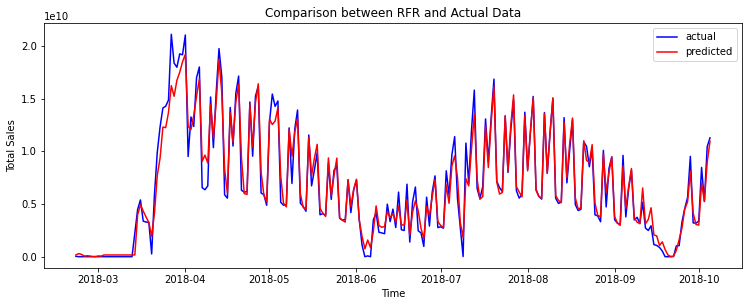

In [182]:
#visualizng how well the predicted RFR predicted sales fit with the data and the forecasted sales
y_train_pred = model_RF.predict(X_train)
index_list = y_train.index.tolist()
prediction = pd.DataFrame({'prediction': y_train_pred}, index=index_list)

plt.gcf().set_size_inches(12.5, 4.5)
plt.title(f'Comparison between RFR and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(y_train, label = 'actual', color='b' ) 
plt.plot(prediction, label = 'predicted', color='r' )
plt.legend()

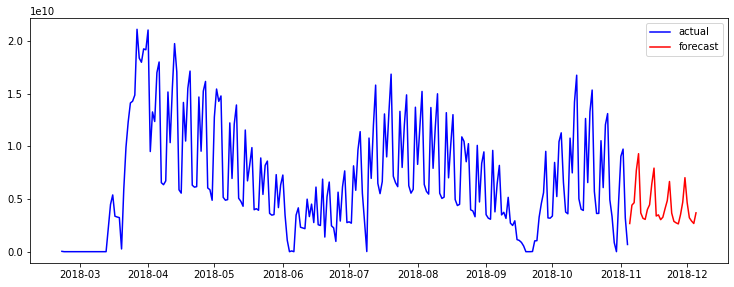

In [186]:
# visualizing the forecastes sales
forecast_date = df_model.index[-1] + pd.DateOffset(days=1)

df_actual= df_model[['total_sales']]
forecast_data = df_forecast[['total_sales']].loc[forecast_date:]

plt.gcf().set_size_inches(12.5, 4.5)
plt.plot(df_actual, label = 'actual', color='b' ) 
plt.plot(forecast_data, label = 'forecast', color='r' )
plt.legend()